# About
Compare performance including and excluding hate against hegemonic groups using a logistic regression classifier.

Could merge with bert_hate_speech_classifier but probably not

# Train and evaluate LR hate speech classifiers
Load data, extract features, train classifiers, evaluate

## With train/dev/test sets

In [10]:
# Load data
import pickle
import pdb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from scipy.stats import chisquare
from IPython.display import display
from tqdm.notebook import tqdm

datasets = [
    'kennedy2020',
    'elsherief2021',
    'salminen2018',
    'sbic',
    'cad',
]

scores = {}
confusion_matrices = {}
f1_scores = [] # List of dicts with keys: dataset, split, f1 (to create df)
sigs = []

# for dataset in datasets[3:4]:
for dataset in tqdm(datasets):
    print(dataset)
    
    path = f'/storage2/mamille3/hegemonic_hate/tmp/{dataset}_hegsplits_0.3hate.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)

    # Extract features
    print('Extracting features...')
    vectorizer = {}
    bow = {}
    for split in ['with_heg', 'no_heg']:
        # Check for NaNs
        if data[split]['train']['text'].isnull().values.any():
            pdb.set_trace()
        if data[split]['test']['text'].isnull().values.any():
            pdb.set_trace()
        vectorizer[split] = TfidfVectorizer(min_df=1)
        vectorizer[split].fit(data[split]['train']['text']) # corpus is a list of strings (documents)
        bow[split] = {}
        bow[split]['train'] = vectorizer[split].transform(data[split]['train']['text'])
        bow[split]['test'] = vectorizer[split].transform(data[split]['test']['text'])
    bow.keys()

    # Train LR model 
    print('Training model...')
    clf = {}
    for split in ['with_heg', 'no_heg']:
        clf[split] = LogisticRegression(solver='liblinear')
        clf[split].fit(bow[split]['train'], data[split]['train']['hate'])

    # Evaluate
    print('Evaluating...')
    scores[dataset] = {}
    confusion_matrices[dataset] = {}
    
    for split in ['with_heg', 'no_heg']:
        preds = clf[split].predict(bow[split]['test'])
        true = data[split]['test']['hate']
        scores[dataset][split] = pd.DataFrame(classification_report(true, preds, output_dict=True))
        f1_scores.append({'dataset': dataset, 'split': split, 'f1_hate': scores[dataset][split].loc['f1-score', 'True']})
        confusion_matrices[dataset][split] = confusion_matrix(true, preds).ravel()
        
        # print(split)
        # display(scores[dataset][split])
        
    print()
        
    # Chi-squared test for significance
    # sig = chisquare(*list(confusion_matrices[dataset].values()))
    sig = chisquare(confusion_matrices[dataset]['with_heg'], confusion_matrices[dataset]['no_heg'])
    sigs.append({'dataset': dataset, 'statistic': sig.statistic, 'pvalue': sig.pvalue})

f1_scores = pd.DataFrame(f1_scores)
display(f1_scores)
sigs = pd.DataFrame(sigs)
sigs

  0%|          | 0/5 [00:00<?, ?it/s]

kennedy2020
Extracting features...
Training model...
Evaluating...

elsherief2021
Extracting features...
Training model...
Evaluating...

salminen2018
Extracting features...
Training model...
Evaluating...

sbic
Extracting features...
Training model...
Evaluating...

cad
Extracting features...
Training model...
Evaluating...



,dataset,split,f1_hate
0,kennedy2020,with_heg,0.531712
1,kennedy2020,no_heg,0.518987
2,elsherief2021,with_heg,0.250477
3,elsherief2021,no_heg,0.288874
4,salminen2018,with_heg,0.550445
5,salminen2018,no_heg,0.550346
6,sbic,with_heg,0.660563
7,sbic,no_heg,0.661484
8,cad,with_heg,0.493709
9,cad,no_heg,0.500600


,dataset,statistic,pvalue
0,kennedy2020,3.690334,0.296902
1,elsherief2021,12.546822,0.005727
2,salminen2018,5.497567,0.138784
3,sbic,0.040398,0.997866
4,cad,0.829893,0.842304


## With cross-validation
Chose to do 5x2 cross-validation for better independence for significance testing. Can just use a t-test then (though might have to be modified)

In [14]:
# Load data
import pickle
import pdb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from scipy.stats import chisquare, ttest_rel, wilcoxon
from IPython.display import display
from tqdm.notebook import tqdm

datasets = [
    'kennedy2020',
    'elsherief2021',
    'salminen2018',
    'sbic',
    'cad',
]

f1_scores = {}

for splits in ['hegsplits', 'controlsplits']:
    
    scores = {}
    f1_scores[splits] = [] # List of dicts with keys: dataset, split, f1 (to create df)
    sigs = []

    # for dataset in datasets[:1]:
    for dataset in tqdm(datasets):
        print(dataset)

        path = f'/storage2/mamille3/hegemonic_hate/tmp/{dataset}_{splits}_0.3hate.pkl'
        with open(path, 'rb') as f:
            data_splits = pickle.load(f)

        vectorizer = {}
        data = {}
        bow = {}
        scores[dataset] = {}
        for split in data_splits:
            # data[split] = pd.concat(data_splits[split].values())
            data[split] = data_splits[split]

            # Check for NaNs
            if data[split]['text'].isnull().values.any():
                pdb.set_trace()

            # Build feature extractor
            vectorizer[split] = TfidfVectorizer(min_df=1)

            # Train, evaluate LR model 
            clf = make_pipeline(vectorizer[split], LogisticRegression(solver='liblinear'))

            scores[dataset][split] = []
            for _ in range(5):
                f1s = cross_validate(clf, data[split]['text'], data[split]['hate'], scoring=['f1'], cv=2)['test_f1'].tolist()
                scores[dataset][split] += f1s
                # confusion_matrices[dataset] = {}

            # preds = clf[split].predict(bow[split]['test'])
            # true = data[split]['test']['hate']
            # scores[dataset][split] = pd.DataFrame(classification_report(true, preds, output_dict=True))
            f1_scores[splits].append({'dataset': dataset, 'split': split, 'f1': np.mean(scores[dataset][split])})
            # confusion_matrices[dataset][split] = confusion_matrix(true, preds).ravel()

            # print(split)
            # display(scores[dataset][split])

        # print()

        splitnames = ['with_special', 'no_special']
        # T-test or Wilcoxon for significance
        # sig = wilcoxon(scores[dataset][splitnames[0]], scores[dataset][splitnames[1]])
        sig = ttest_rel(scores[dataset][splitnames[0]], scores[dataset][splitnames[1]])
        sigs.append({'dataset': dataset, 
                     f'{splitnames[1]} > {splitnames[0]}': np.mean(scores[dataset][splitnames[1]]) > np.mean(scores[dataset][splitnames[0]]), 
                     'p < 0.05': sig.pvalue < 0.05, 'pvalue': sig.pvalue, 'statistic': sig.statistic,})

        # Chi-squared test for significance
        # sig = chisquare(*list(confusion_matrices[dataset].values()))
        # sig = chisquare(confusion_matrices[dataset]['with_heg'], confusion_matrices[dataset]['no_heg'])
        # sigs.append({'dataset': dataset, 'statistic': sig.statistic, 'pvalue': sig.pvalue})
        
    # Save out CV scores
    with open(f'/storage2/mamille3/hegemonic_hate/tmp/{splits}_5x2cv_scores.pkl', 'wb') as f:
        pickle.dump(scores, f)

    print(splits)
    f1_df = pd.DataFrame(f1_scores[splits])
    display(f1_df)
    sigs_df = pd.DataFrame(sigs)
    display(sigs_df)
    print('************************')

  0%|          | 0/5 [00:00<?, ?it/s]

kennedy2020
elsherief2021
salminen2018
sbic
cad
hegsplits


,dataset,split,f1
0,kennedy2020,with_special,0.518925
1,kennedy2020,no_special,0.513553
2,elsherief2021,with_special,0.404021
3,elsherief2021,no_special,0.428284
4,salminen2018,with_special,0.709761
5,salminen2018,no_special,0.717852
6,sbic,with_special,0.622401
7,sbic,no_special,0.622313
8,cad,with_special,0.449591
9,cad,no_special,0.465504


,dataset,no_special > with_special,p < 0.05,pvalue,statistic
0,kennedy2020,False,False,3.247428e-01,1.041658
1,elsherief2021,True,True,1.211881e-12,-54.366875
2,salminen2018,True,False,5.711018e-01,-0.587826
3,sbic,False,False,9.457930e-01,0.069911
4,cad,True,True,4.146184e-02,-2.376545


************************


  0%|          | 0/5 [00:00<?, ?it/s]

kennedy2020
elsherief2021
salminen2018
sbic
cad
controlsplits


,dataset,split,f1
0,kennedy2020,with_special,0.519512
1,kennedy2020,no_special,0.496061
2,elsherief2021,with_special,0.431223
3,elsherief2021,no_special,0.422231
4,salminen2018,with_special,0.715067
5,salminen2018,no_special,0.717081
6,sbic,with_special,0.620993
7,sbic,no_special,0.627174
8,cad,with_special,0.455323
9,cad,no_special,0.461855


,dataset,no_special > with_special,p < 0.05,pvalue,statistic
0,kennedy2020,False,True,0.000003,10.260957
1,elsherief2021,False,True,0.002694,4.095755
2,salminen2018,True,False,0.523261,-0.664121
3,sbic,True,True,0.000006,-9.468621
4,cad,True,False,0.416317,-0.851984


************************


In [15]:
# Test Wilcoxon significance
# Load CV scores
sigs = []
splits = 'hegsplits'
with open(f'/storage2/mamille3/hegemonic_hate/tmp/{dataset}_{splits}_5x2cv_scores.pkl', 'rb') as f:
    scores = pickle.load(f)
    
for dataset in datasets:
    sig = wilcoxon(scores[dataset][splitnames[0]], scores[dataset][splitnames[1]])
    sigs.append({'dataset': dataset, 
                 f'{splitnames[1]} > {splitnames[0]}': np.mean(scores[dataset][splitnames[1]]) > np.mean(scores[dataset][splitnames[0]]), 
                 'p < 0.05': sig.pvalue < 0.05, 'pvalue': sig.pvalue, 'statistic': sig.statistic,})
        
sigs_df = pd.DataFrame(sigs)
sigs_df

,dataset,no_special > with_special,p < 0.05,pvalue,statistic
0,kennedy2020,False,False,0.232422,15.0
1,elsherief2021,True,True,0.001953,0.0
2,salminen2018,True,False,0.232422,15.0
3,sbic,False,False,0.232422,15.0
4,cad,True,False,0.232422,15.0


# Visualize scores

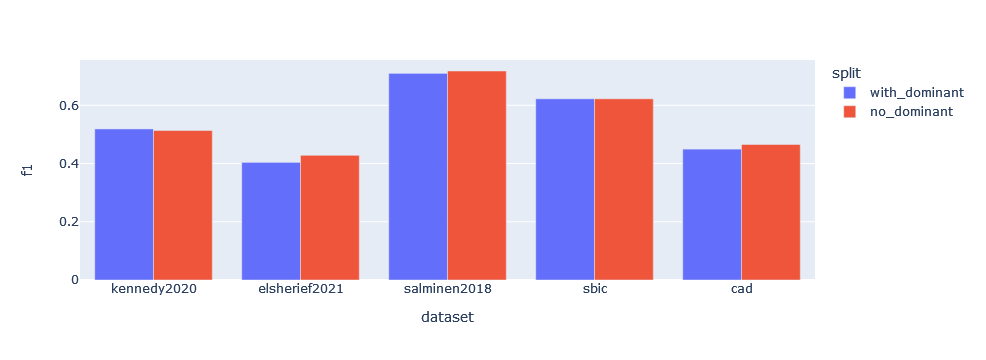

In [23]:
import plotly.express as px

f1s = pd.DataFrame(f1_scores['hegsplits']).replace('with_special', 'with_dominant').replace('no_special', 'no_dominant')
f1s

px.bar(f1s, x='dataset', y='f1', color='split', barmode='group')

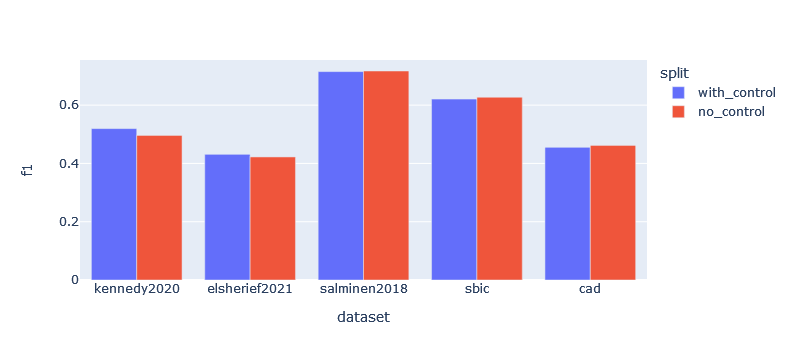

In [24]:
import plotly.express as px

f1s = pd.DataFrame(f1_scores['controlsplits']).replace('with_special', 'with_control').replace('no_special', 'no_control')
f1s

px.bar(f1s, x='dataset', y='f1', color='split', barmode='group')

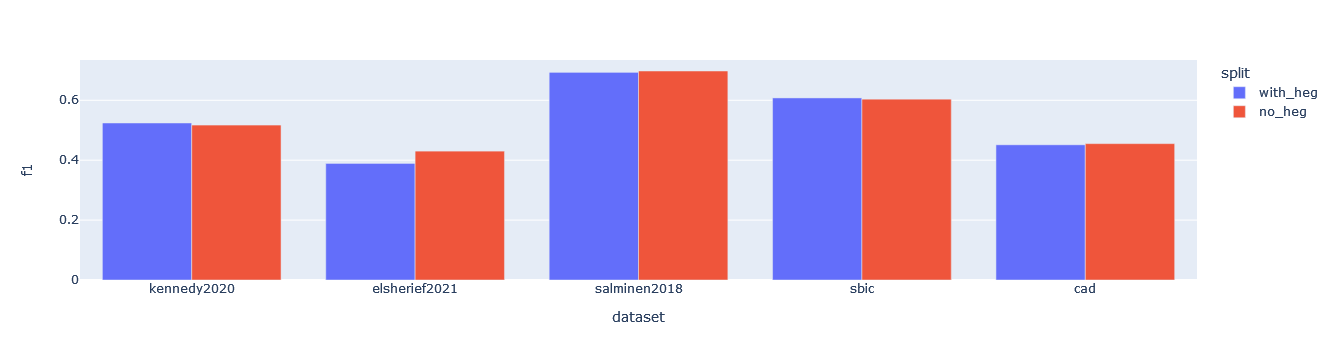

In [26]:
# Hegemonic (old results)

import plotly.express as px

# px.bar(f1_scores, x='dataset', y='f1_hate', color='split', barmode='group')
px.bar(f1_scores, x='dataset', y='f1', color='split', barmode='group')